# Movie Recommendation Using NLP

### Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import io
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from skimage import io
from IPython.display import clear_output
pd.set_option('display.max_colwidth', None)

## Data Preprocessing

In [2]:
# read the dataset https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies
df = pd.read_csv('movies.csv')

In [3]:
# drop movies that have a short description
df['word_count'] = df['overview'].apply(lambda x: len(str(x).split()))
df = df[df['word_count'] >= 50]
df.drop('word_count', axis=1, inplace=True)

In [4]:
# drop all duplicates
df.drop_duplicates(subset=['title', 'release_date'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
# Drop rows with missing poster_path
df.dropna(subset=['poster_path'], inplace=True)

In [6]:
# fill empty cells
df.fillna(value={i: '' for i in ['overview', 'genres', 'keywords', 'credits']}, inplace=True)

In [7]:
# lambda function to preprocess string data
strOp= lambda x: ' '.join(x.split('-'))

In [8]:
# add keywords, genres and credits to overview for full information
df.overview = df.overview + df.keywords.apply(strOp) + df.genres.apply(strOp) + df.credits.apply(lambda x: ' '.join(x.replace(' ', '').split('-')[:3]))
# example
# df.overview[0]

### Initialize the TF-IDF Vectorizer to transform text data into vectors

#### only run these lines once!

In [9]:
# TF-IDF Vectorizer to transform words into numbers and remove common english words like 'the'
tfidf = TfidfVectorizer(stop_words='english')

In [10]:
# transform overview data with TF-IDF vectorizer to create matrix
tfidf_matrix = tfidf.fit_transform(df['overview'])

In [11]:
#display some columns with vectorized words
display(pd.DataFrame(
    tfidf_matrix[:5, 10000:10005].toarray(),
    columns= tfidf.get_feature_names()[10000:10005],
    index = df.title[:5]).round())

print(tfidf_matrix.shape)
# over 970000 different words used to describe all movies

,adventurebriankeith,adventurebrians,adventurebrigitteauber,adventurebrookeshields,adventurebruceallpress
title,,,,,
Avatar: The Way of Water,0.0,0.0,0.0,0.0,0.0
Ant-Man and the Wasp: Quantumania,0.0,0.0,0.0,0.0,0.0
Creed III,0.0,0.0,0.0,0.0,0.0
Knock at the Cabin,0.0,0.0,0.0,0.0,0.0
Black Panther: Wakanda Forever,0.0,0.0,0.0,0.0,0.0


(157235, 440744)


## Movie Recommendation

### Initialize the recommendation function

In [12]:

def get_recommendation(user_input):
    # Vectorize user input
    vectorized_input = tfidf.transform([user_input])

    # Calculate cosine similarity between user input and movie overviews
    similarity_scores = cosine_similarity(vectorized_input, tfidf_matrix)

    # Get the indices of top similar movies
    top_indices = similarity_scores.argsort()[0][::-1][:3]

    # Retrieve the top recommended movies
    recommended_movies = df.iloc[top_indices]

    # Display movie posters for the recommended movies
    fig, ax = plt.subplots(1, 3, figsize=(15, 20))
    ax = ax.flatten()
    for i, j in enumerate(recommended_movies.poster_path):
        try:
            ax[i].axis('off')
            ax[i].set_title(recommended_movies.iloc[i].title, fontsize=22)
            a = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
            ax[i].imshow(a)
        except:
            pass
    fig.tight_layout()
    plt.show()
    print()
    print(recommended_movies.overview)
    
    # Prompt user for feedback
    feedback = input("Does one of these movies sound interesting? (Y/N): ")

    if feedback.upper() == "Y":
        print("Great! Enjoy your movies.")
    elif feedback.upper() == "N":
        clear_output()
        print("Okay, here are alternative movies:")

        # Get the next top indices (excluding the previous top indices)
        next_top_indices = similarity_scores.argsort()[0][::-1][3:6]

        # Retrieve the next top recommended movies
        next_recommended_movies = df.iloc[next_top_indices]
        
        # Display movie posters for the recommended movies
        fig, ax = plt.subplots(1, 3, figsize=(15, 20))
        ax = ax.flatten()
        for i, j in enumerate(next_recommended_movies.poster_path):
            try:
                ax[i].axis('off')
                ax[i].set_title(next_recommended_movies.iloc[i].title, fontsize=22)
                a = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
                ax[i].imshow(a)
            except:
                pass
        fig.tight_layout()
        plt.show()
        print()
        print(next_recommended_movies.overview)
        
    else:
        print("Invalid input. Please enter Y for 'Yes' or N for 'No'.")

### Ask for User Input

In [15]:
# replace the string with a description of the type of movie you'd like to see
user_input = "Girl falls in Love with a Vampire"

def get_genre_recommendation(genres):
    # Filter movies based on selected genres
    selected_movies = df[df['genres'].str.contains(genres, case=False, na=False)]

    # If there are no movies matching the selected genre, display an error message
    if selected_movies.empty:
        print("Sorry, no movies found for the selected genre.")
        return

    # Vectorize the movie overviews for selected movies
    selected_tfidf_matrix = tfidf.transform(selected_movies['overview'])

    # Vectorize user input
    vectorized_input = tfidf.transform([user_input])

    # Calculate cosine similarity between user input and movie overviews
    similarity_scores = cosine_similarity(vectorized_input, selected_tfidf_matrix)

    # Get the indices of top similar movies
    top_indices = similarity_scores.argsort()[0][::-1][:3]

    # Retrieve the top recommended movies
    recommended_movies = selected_movies.iloc[top_indices]

    # Display movie posters for the recommended movies
    fig, ax = plt.subplots(1, 3, figsize=(15, 20))
    ax = ax.flatten()
    for i, j in enumerate(recommended_movies.poster_path):
        try:
            ax[i].axis('off')
            ax[i].set_title(recommended_movies.iloc[i].title, fontsize=22)
            a = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
            ax[i].imshow(a)
        except:
            pass
    fig.tight_layout()
    plt.show()
    print()
    print(recommended_movies.overview)

# Prompt user for genre selection
genre_input = input("Please select a genre from the following options:\n"
                    "Action, Adventure, Animation, Comedy, Crime, Documentary, Drama, Family, Fantasy, "
                    "History, Horror, Music, Mystery, Romance, Science Fiction, Thriller, TV Movie, War, Western\n"
                    "Enter your selection: ")

# Get recommendation based on selected genre
get_genre_recommendation(genre_input)### Show Recommendations

Please enter up to three genres separated by commas:
Action, Adventure, Animation, Comedy, Crime, Documentary, Drama, Family, Fantasy, History, Horror, Music, Mystery, Romance, Science Fiction, Thriller, TV Movie, War, Western
Enter your selection: Comedy,Romance,Family


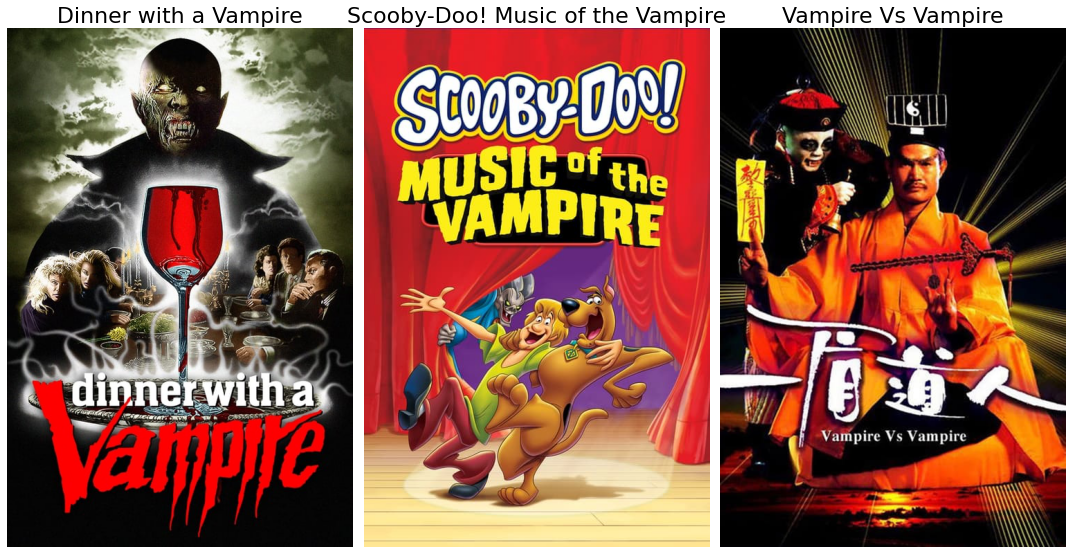


31438                                                                                                                                                                                                                                                                                                                                                                                                                                                                A camera crew unearths a thousand year old vampire from Mesopotamia. Years after his rise from the grave the vampire becomes a famous horror film director and holds auditions for his up and coming film. Four young hopefuls are chosen and are invited to spend the night at the vampire's house. At dinner the vampire reveals his true nature to his guests and the real reason why they are there to kill him before dawn as he has grown bored with his existence.movie business vampire b movie dinner auditionHorror Comedy TV MovieGeorgeHilton Patrizia

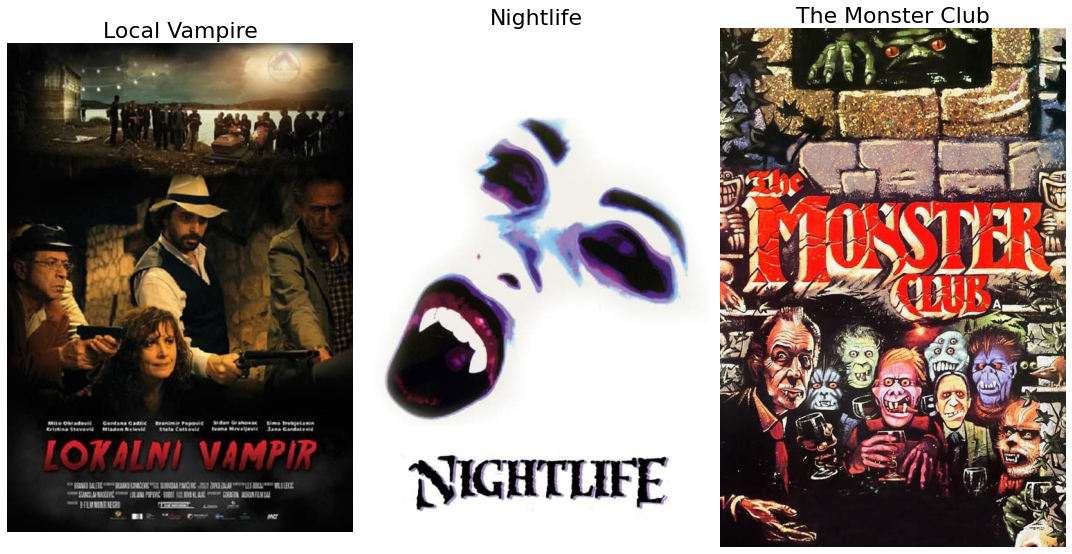


76753    When a passive young businessman is conned and thrown into great debts he and his mother concoct a desperate escape plan - to fake his death stage a funeral then hide him out in the attic. When he sneaks out to visit his girlfriend he is spotted by the neighbors who jump to the conclusion that he is a vampire risen from the dead. It's not long before the news of a lurking vampire attracts waves of tourists including some mobsters who aren't completely sold on this whole vampire story.vampire fake death revenge plot montenegroComedyVojislavKrivokapić GordanaGadžić StelaĆetković
36018                                                                                                                                                                                     At a museum of Mexico City arrives a perfectly conservated mumie. It is a vampire who has died years ago and who returns to life in search of his lost love Angelique. But unfortunately for him the young woman has met a d

In [19]:
def get_genre_recommendation(genres):
    # Split the input genres by comma and convert to lowercase
    selected_genres = [genre.strip().lower() for genre in genres.split(',')]

    # Filter movies based on selected genres
    selected_movies = df[df['genres'].str.lower().str.contains('|'.join(selected_genres), na=False)]

    # If there are no movies matching the selected genres, display an error message
    if selected_movies.empty:
        print("Sorry, no movies found for the selected genres.")
        return

    # Vectorize the movie overviews for selected movies
    selected_tfidf_matrix = tfidf.transform(selected_movies['overview'])

    # Vectorize user input
    vectorized_input = tfidf.transform([user_input])

    # Calculate cosine similarity between user input and movie overviews
    similarity_scores = cosine_similarity(vectorized_input, selected_tfidf_matrix)

    # Get the indices of top similar movies
    top_indices = similarity_scores.argsort()[0][::-1][:3]

    # Retrieve the top recommended movies
    recommended_movies = selected_movies.iloc[top_indices]

    # Display movie posters for the recommended movies
    fig, ax = plt.subplots(1, 3, figsize=(15, 20))
    ax = ax.flatten()
    for i, j in enumerate(recommended_movies.poster_path):
        try:
            ax[i].axis('off')
            ax[i].set_title(recommended_movies.iloc[i].title, fontsize=22)
            a = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
            ax[i].imshow(a)
        except:
            pass
    fig.tight_layout()
    plt.show()
    print()
    print(recommended_movies.overview)

    # Prompt user for feedback
    feedback = input("Does one of these movies sound interesting? (Y/N): ")

    if feedback.upper() == "Y":
        print("Great! Enjoy your movie.")
    elif feedback.upper() == "N":
        print("Okay, here are alternative movies:")

        # Get the next top indices (excluding the previous top indices)
        next_top_indices = similarity_scores.argsort()[0][::-1][3:6]

        # Retrieve the next top recommended movies
        next_recommended_movies = selected_movies.iloc[next_top_indices]

        # Display movie posters for the alternative movies
        fig, ax = plt.subplots(1, 3, figsize=(15, 20))
        ax = ax.flatten()
        for i, j in enumerate(next_recommended_movies.poster_path):
            try:
                ax[i].axis('off')
                ax[i].set_title(next_recommended_movies.iloc[i].title, fontsize=22)
                a = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
                ax[i].imshow(a)
            except:
                pass
        fig.tight_layout()
        plt.show()
        print()
        print(next_recommended_movies.overview)

# Prompt user for genre selection
genre_input = input("Please enter up to three genres separated by commas:\n"
                    "Action, Adventure, Animation, Comedy, Crime, Documentary, Drama, Family, Fantasy, "
                    "History, Horror, Music, Mystery, Romance, Science Fiction, Thriller, TV Movie, War, Western\n"
                    "Enter your selection: ")

# Get recommendation based on selected genres
get_genre_recommendation(genre_input)




#get_recommendation(user_input)